In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import shap


In [26]:
import pandas as pd
import numpy as np

# Load features and metadata
features_df = pd.read_csv("/rds/general/user/nk2622/home/tremor_features_per_participant.csv")
meta_df = pd.read_csv("/rds/general/user/nk2622/home/final_metadata_PD_HC_trimmed_ON_OFF.csv")

# Ensure IDs are strings
features_df['participant_id'] = features_df['participant_id'].astype(str)
meta_df['participant_id'] = meta_df['participant_id'].astype(str)

# Create ON_OFF label based on LEDD
meta_df['ON_OFF'] = (meta_df['ledd'] > 0).astype(int)  # OFF = 0, ON = 1

# Merge dataframes
merged_df = features_df.merge(
    meta_df[['participant_id', 'ON_OFF', 'ledd', 'cohort_group']],
    on='participant_id', how='left'
)

# Drop missing labels
merged_df = merged_df.dropna(subset=['ON_OFF'])

# Confirm merge
print("Merged shape:", merged_df.shape)
print("Class distribution:\n", merged_df['ON_OFF'].value_counts())


Merged shape: (4002, 14)
Class distribution:
 1.0    2816
0.0    1186
Name: ON_OFF, dtype: int64


In [27]:
# Select features and target
feature_cols = ['tremor_amp', 'tremor_bandpower', 'entropy', 'sma']
X = merged_df[feature_cols]
y = merged_df['ON_OFF']


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10, verbosity=1),
    'SVM': SVC(kernel='linear', probability=True)  #  No backslash here
}

trained_models = {}

# Train each model with error catching
for name, model in models.items():
    try:
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model
        print(f"{name} trained successfully.")
    except Exception as e:
        print(f"{name} failed to train: {e}")


Logistic Regression trained successfully.
Random Forest trained successfully.
XGBoost trained successfully.
SVM trained successfully.


In [30]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Print reports
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {model.score(X_test_scaled, y_test):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")



Logistic Regression Performance:
              precision    recall  f1-score   support

         0.0       0.76      0.12      0.20       237
         1.0       0.73      0.98      0.84       564

    accuracy                           0.73       801
   macro avg       0.74      0.55      0.52       801
weighted avg       0.74      0.73      0.65       801

Accuracy: 0.7278
AUC-ROC: 0.6802

Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.84      0.64      0.72       237
         1.0       0.86      0.95      0.90       564

    accuracy                           0.86       801
   macro avg       0.85      0.79      0.81       801
weighted avg       0.85      0.86      0.85       801

Accuracy: 0.8564
AUC-ROC: 0.8710

XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.84      0.64      0.72       237
         1.0       0.86      0.95      0.90       564

    accuracy                    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


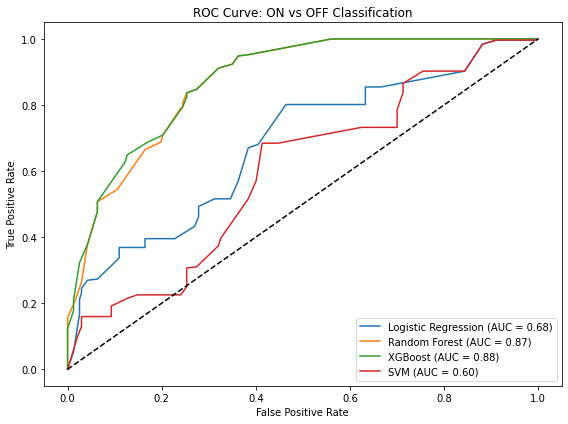

In [31]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: ON vs OFF Classification")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_on_off_ledd.png", dpi=300)
plt.show()
